In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

from pandas import set_option
set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None

filename = 'data/facies_vectors.csv'
training_data = pd.read_csv(filename)
training_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,3232.000000,4149.000000,4149.000000
mean,4.503254,2906.867438,64.933985,0.659566,4.402484,13.201066,3.725014,1.518438,0.521852
std,2.474324,133.300164,30.302530,0.252703,5.274947,7.132846,0.896152,0.499720,0.286644
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000
25%,2.000000,2821.500000,44.730000,0.498000,1.600000,8.500000,NaN,1.000000,0.277000
50%,4.000000,2932.500000,64.990000,0.639000,4.300000,12.020000,NaN,2.000000,0.528000
75%,6.000000,3007.000000,79.438000,0.822000,7.500000,16.050000,NaN,2.000000,0.769000
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000


###  We build a function to create new variables representing the absolute distance of a deposit to an upper marine context (younger) and one for the distance to a deeper marine context (older)

In [2]:
def make_dist_mar_vars(wells_df):
 
    grouped = wells_df.groupby(['Well Name'])
    new_df = pd.DataFrame()
    
    for key in grouped.groups.keys():
    
        NM_M = grouped.get_group(key)['NM_M'].values

        #We create a temporary dataframe that we reset for every well
        temp_df = pd.DataFrame()
        temp_df['Depth'] = grouped.get_group(key)['Depth']
        temp_df['Well Name'] = [key for _ in range(len(NM_M))]

        #We initialize new variables
        dist_mar_up = np.zeros(len(NM_M))
        dist_mar_down = np.zeros(len(NM_M))

        # A variable counting the interval from the upper marine deposit an one for bottom lower deposit
        # We initialize them to -99999 since we do not know what's above the first log
        count = -99999
        
        #we build them in two seperate loops
        for i in range(len(NM_M)):

            if ((NM_M[i] == 1) & (count>-99999)):

                count+=0.5
                dist_mar_up[i] += count

            elif NM_M[i] == 2:

                count=0

            else:
                dist_mar_up[i] = count

        #********************************************#
        #we reset count
        count = -99999
        
        for i in range(len(NM_M)-1,-1,-1):
               
            if ((NM_M[i] == 1) & (count>-99999)):

                count+=0.5
                dist_mar_down[i] += count

            elif NM_M[i] == 2:            
                count=0

            else:
                dist_mar_down[i] = count
                
        #********************************************#       

        temp_df['dist_mar_up'] = dist_mar_up
        temp_df['dist_mar_down'] = dist_mar_down
#         temp_df['ratio_NM_M'] = [np.mean(NM_M[i:i+50]) if i<(len(NM_M)-50) else np.mean(NM_M[i:]) for i in range(len(NM_M))]
    
        # We append each well variable to a larger dataframe
        # We use a dataframe to preserve the index
        new_df = new_df.append(temp_df) 
        
    new_df = new_df.sort_index()
    new_df = new_df.drop(['Well Name','Depth'],axis=1)
    
    #We don't use merge as it creates duplicates for curious reasons that we later have to drop
    return pd.concat([wells_df,new_df],axis=1)

In [3]:
training_data = make_dist_mar_vars(training_data)
training_data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,dist_mar_up,dist_mar_down
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000,-99999.0,21.5
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979,-99999.0,21.0
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957,-99999.0,20.5
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936,-99999.0,20.0
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915,-99999.0,19.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4144,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685,0.0,0.0
4145,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677,0.0,0.0
4146,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669,0.0,0.0
4147,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661,0.0,0.0


### Assign category integer to Formation variable

In [4]:
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
training_data['Formation_category'] = LE.fit_transform(training_data.Formation)
training_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,dist_mar_up,dist_mar_down,Formation_category
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,3232.000000,4149.000000,4149.000000,4149.000000,4149.00000,4149.000000
mean,4.503254,2906.867438,64.933985,0.659566,4.402484,13.201066,3.725014,1.518438,0.521852,-9781.547481,5.09677,6.434322
std,2.474324,133.300164,30.302530,0.252703,5.274947,7.132846,0.896152,0.499720,0.286644,29716.387851,7.75078,4.722771
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000,-99999.000000,0.00000,0.000000
25%,2.000000,2821.500000,44.730000,0.498000,1.600000,8.500000,NaN,1.000000,0.277000,0.000000,0.00000,2.000000
50%,4.000000,2932.500000,64.990000,0.639000,4.300000,12.020000,NaN,2.000000,0.528000,0.000000,0.00000,7.000000
75%,6.000000,3007.000000,79.438000,0.822000,7.500000,16.050000,NaN,2.000000,0.769000,5.500000,8.50000,12.000000
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000,46.000000,46.00000,13.000000


### We import the ensemble module from sklearn and the metrics module

In [5]:
from sklearn import metrics
from sklearn import ensemble

In [6]:
##### Creating new variable
grouped = training_data.groupby('Well Name')

new_var = pd.DataFrame()

for key in grouped.groups.keys():

    NM_M = grouped.get_group(key)['NM_M'].values
    
    #We create a temporary dataframe that we reset for every well
    temp_df = pd.DataFrame()
    temp_df['Depth'] = grouped.get_group(key)['Depth']
    temp_df['Well Name'] = [key for _ in range(len(NM_M))]
    temp_df['NM_M'] = grouped.get_group(key)['NM_M']
    #We initialize a new variable
    temp_df['ratio_40m_centered'] = pd.rolling_mean(arg=temp_df['NM_M'], window=80, min_periods=1, center=True)

    # We append each well variable to a larger dataframe
    # We use a dataframe to preserve the index
    new_var = new_var.append(temp_df)

In [7]:
new_var = new_var.sort_index()
new_var =new_var.drop(['Well Name','Depth','NM_M'],axis=1)
training_data =  pd.concat([training_data,new_var],axis=1)
training_data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,dist_mar_up,dist_mar_down,Formation_category,ratio_40m_centered
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000,-99999.0,21.5,1,1.000000
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979,-99999.0,21.0,1,1.000000
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957,-99999.0,20.5,1,1.000000
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936,-99999.0,20.0,1,1.000000
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915,-99999.0,19.5,1,1.022727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4144,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685,0.0,0.0,12,1.977778
4145,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677,0.0,0.0,12,2.000000
4146,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669,0.0,0.0,12,2.000000
4147,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661,0.0,0.0,12,2.000000


### Let's see how well NM_M variable discriminates facies

In [8]:
id_NM = training_data.NM_M == 1
id_M = training_data.NM_M == 2

#we count with th GR variable since there is no missing value
NM_count = training_data[id_NM].groupby(['Facies'])['GR'].count()
M_count = training_data[id_M].groupby(['Facies'])['GR'].count()

In [9]:
pos_NM = list(np.arange(0.1,8.1,1))
pos_M = list(np.arange(1.5,9.5,1)) 
pos_M

[1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]

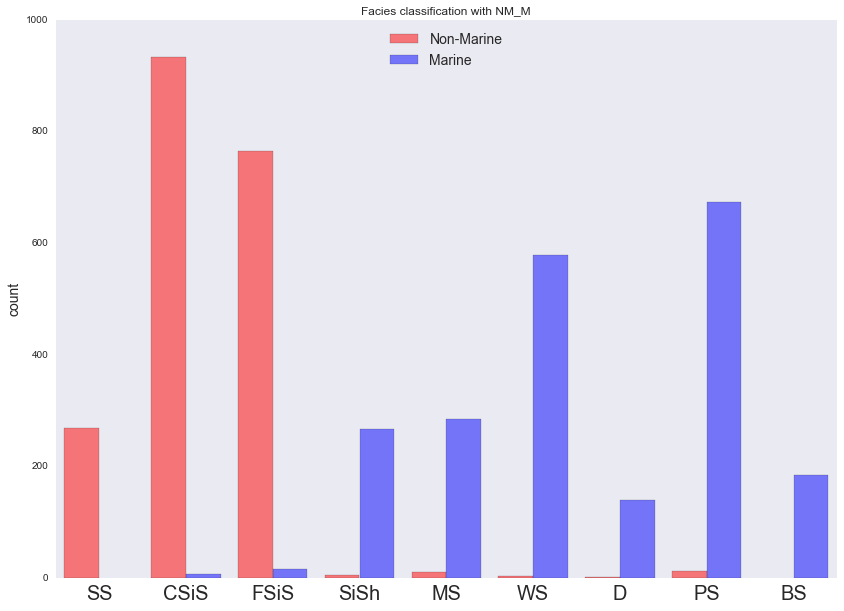

In [10]:
import seaborn as sns
facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS','WS', 'D','PS', 'BS']
fig, ax = plt.subplots(figsize=(14,10))

plt.bar(pos_NM, NM_count.values, 0.4,
                 alpha=0.5,
                 color='r',
                 label='Non-Marine')

plt.bar(pos_M, M_count.values, 0.4,
                 alpha=0.5,
                 color='b',
                 label='Marine')

# Setting axis labels and ticks
ax.set_ylabel('count',fontsize=14)
ax.set_title('Facies classification with NM_M')
ax.set_xticks(np.arange(0.5,10))
ax.set_xticklabels(facies_labels, fontsize=20)
ax.set_xlim([0,9])

# Adding the legend and showing the plot
plt.legend(['Non-Marine','Marine'], loc='upper center', fontsize=14)
plt.grid()
plt.show()

### We can live with a small percentage of misclassification from the NM_M variable. We separate our dataset in marine and non-marine sediments assuming that facies 1-3 are NM and 4-9 are M (NM_M ==2)

In [11]:
NM_training_data = training_data[id_NM]
M_training_data = training_data[id_M]

# The algorithm can't use directly NaN but we don't have to drop the data if we assign an extreme value
NM_training_data.replace(to_replace=np.nan,value=-99999,inplace=True)
M_training_data.replace(to_replace=np.nan,value=-99999,inplace=True)

NM_training_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,dist_mar_up,dist_mar_down,Formation_category,ratio_40m_centered
count,1998.000000,1998.000000,1998.000000,1998.000000,1998.000000,1998.000000,1998.000000,1998.0,1998.000000,1998.000000,1998.000000,1998.000000,1998.000000
mean,2.314314,2867.824825,74.877176,0.530167,5.373860,16.760651,-18866.134227,1.0,0.511736,-20312.132382,10.583834,6.546046,1.355157
std,0.854635,133.370818,15.233573,0.160396,6.147445,7.699085,39136.744191,0.0,0.288464,40251.953018,8.165698,4.357650,0.197613
min,1.000000,2573.500000,26.060000,-0.025949,-19.900000,3.950000,-99999.000000,1.0,0.000000,-99999.000000,0.500000,0.000000,1.000000
25%,2.000000,2776.625000,64.378000,0.438000,2.700000,11.950000,2.486000,1.0,0.259250,1.000000,4.000000,3.000000,1.212500
50%,2.000000,2893.750000,73.704000,0.542000,5.800000,14.908750,3.057000,1.0,0.500000,6.000000,9.000000,7.000000,1.362500
75%,3.000000,2969.000000,83.936000,0.633000,9.300000,19.212750,3.364750,1.0,0.763000,12.000000,15.000000,11.000000,1.500000
max,8.000000,3111.500000,183.375000,0.966000,19.257000,84.400000,5.100000,1.0,1.000000,46.000000,46.000000,13.000000,1.921875


### We drop unused variables for marine and non-marine dataset (we prepare the list here)
#### N.B this operation is based on geological knowledge and feature importance from previous tests

In [12]:
nm_drop_list = ['Formation', 'Well Name', 'Depth',
                                     'Facies','DeltaPHI','PE','NM_M','dist_mar_down','dist_mar_up','RELPOS']
m_drop_list = ['Formation', 'Well Name', 'Depth',
                                      'Facies','dist_mar_down','dist_mar_up','PE','NM_M','PHIND','ratio_40m_centered']

In [13]:
#We prepare our estimator
clf = ensemble.RandomForestClassifier(n_estimators=500,n_jobs=-1)

In [23]:
from sklearn.model_selection import LeaveOneGroupOut
logo = LeaveOneGroupOut()
training_data.replace(to_replace=np.nan,value=-99999,inplace=True)
wells = training_data['Well Name'].values
X = training_data.drop(['Formation', 'Well Name', 'Depth',
                                     'Facies','dist_mar_down','dist_mar_up','ratio_40m_centered'],axis=1).values
y = training_data.Facies.values

In [24]:
new_df = pd.DataFrame()
scores = []
for train,test in logo.split(X,y,groups = wells):
    
    temp_df = pd.DataFrame()
    
    X_test,X_train,y_test,y_train = X[test],X[train],y[test],y[train]
    well_name = wells[test[0]]
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)

    #Scoring
    conf_mat = metrics.confusion_matrix(y_test,y_pred)
    print(conf_mat)
    
    try:
        score = metrics.f1_score(y_test, y_pred,average='weighted')
    except:
        #this exception is for Recruit F9
        score = metrics.f1_score(y_test, y_pred)
    scores.append(score)
    print('********')
    print('Blind well is {0}, F1 score : {1:.4%}\n'.format(well_name,score))


    temp_df['True Facies'] = y_test
    temp_df['Predicted Facies'] = y_pred

    temp_df['Well Name'] = [well_name for _ in range(len(y_test))]
    new_df = new_df.append(temp_df)

print("="*30)
print('*********** RESULT ***********')
print("="*30)
print('\nAverage  F1-score is {:.4%}'.format(np.mean(scores)))

[[82 35  0  0  0  0  0  0]
 [10 81  0  0  0  0  0  0]
 [ 0  0 38  1  3  1  1  0]
 [ 0  0  4 12  1  2  7  0]
 [ 0  0 15 25  7 11 11  0]
 [ 0  0  0  4  1 10  0  1]
 [ 0  0  7 10 10 28 43  0]
 [ 0  0  0  0  0  0  0  5]]
********
Blind well is ALEXANDER D, F1 score : 58.9122%

[[ 0  8  0  0  0  0  0  0  0]
 [ 2 34 19  0  0  0  0  1  0]
 [ 0  8 37  1  1  0  0  4  0]
 [ 0  0  0  4  0  7  0  2  0]
 [ 0  0  1  3  6 15  0  5  0]
 [ 0  0  0 11  0 58  0 18  0]
 [ 0  0  1  0  0  1  6 23  3]
 [ 0  1  2  1  0 21  0 48  2]
 [ 0  0  0  0  0  0  0  0 50]]
********
Blind well is CHURCHMAN BIBLE, F1 score : 58.0681%

[[ 37 104  17   0   0   0   0   0]
 [  2  70  66   0   0   0   0   4]
 [  0   6  35   0   0   0   0   6]
 [  0   0   4   7   0  14   0   0]
 [  0   4   3   0   4  14   0   3]
 [  0   0   0   0   0  22   1   8]
 [  0   0   0   0   0   0   1   1]
 [  0   0   4   1   2  31   4  26]]
********
Blind well is CROSS H CATTLE, F1 score : 39.7965%

[[ 0  6  3  0  0  0  0  0  0]
 [ 0 72 13  0  0  0  0 

In [ ]:
# 1=sandstone  2=c_siltstone   3=f_siltstone 
# 4=marine_silt_shale 5=mudstone 6=wackestone 7=dolomite
# 8=packstone 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

In [ ]:
#Function modified from initial submission by Brendon Hall

def make_facies_pred_plot(df_pred,facies_colors):
#     make sure logs are sorted by depth
    df_pred = df_pred.sort_values(by='Depth')
    
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    import matplotlib.gridspec as gridspec
    

    gs0 = gridspec.GridSpec(3,4)
    
    fig=plt.figure(figsize=(20,40))
    
    for i,name in zip(range(10),np.unique(df_pred['Well Name'])):
               
        idx = (df_pred['Well Name'] == name)
        cluster_test=np.repeat(np.expand_dims(df_pred[idx]['True Facies'].values,1), 100, 1)
        cluster_pred=np.repeat(np.expand_dims(df_pred[idx]['Predicted Facies'].values,1), 100, 1)
        
        ztop=df_pred[idx].Depth.min(); zbot=df_pred[idx].Depth.max()
        
        gs00 = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=gs0[i])
       
        ax=[]
        ax.append(plt.subplot(gs00[0]))
        ax.append(plt.subplot(gs00[1]))
        
        im_test=ax[0].imshow(cluster_test, interpolation='none', aspect='auto',
                        cmap=cmap_facies,vmin=1,vmax=9,extent=[0,100,zbot,ztop])

        im_pred=ax[1].imshow(cluster_pred, interpolation='none', aspect='auto',
                        cmap=cmap_facies,vmin=1,vmax=9,extent=[0,100,zbot,ztop])

        divider = make_axes_locatable(ax[1])
        cax = divider.append_axes("right", size="20%", pad=0.05)
        cbar=plt.colorbar(im_pred, cax=cax)
        cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                    'SiSh', ' MS ', ' WS ', ' D  ', 
                                    ' PS ', ' BS ']))
        cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')

        for i in range(len(ax)):
            ax[i].set_ylim(ztop,zbot)
            ax[i].invert_yaxis()
            ax[i].grid()
            ax[i].locator_params(axis='x', nbins=3)

        ax[0].set_xlabel('Intepreted Facies')
        ax[1].set_xlabel('Predicted Facies')

        ax[1].set_xticklabels([])
        ax[1].set_yticklabels([])
        ax[0].set_xticklabels([])

        ax[0].set_title('Well: %s' % name, fontsize=14)

In [ ]:
make_facies_pred_plot(new_df,facies_colors)

In [ ]:
# new_df.to_pickle('Facies_prediction_ml_contest.pkl')

### Seems like we perform better in certain wells. Of course, there are statistical discrepancy between wells. Normally we should score better in wells that are close to the global statistics of the dataset. Let's check that out.

In [ ]:
cm = sns.diverging_palette(220, 20, n=7,as_cmap=True)

grouped = training_data.groupby('Well Name').mean()
grouped['F1_score'] = scores
grouped.style.background_gradient(cmap=cm)

In [ ]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2,ncols=2)

ax1.plot(grouped.NM_M,grouped.F1_score,'o')
ax1.set_xlabel('mean NM_M')
ax1.set_ylabel('F1_score')
      
ax2.plot(grouped.ILD_log10,grouped.F1_score,'o')
ax2.set_xlabel('mean ILD')
ax2.set_ylabel('F1_score')
      
ax3.plot(grouped.PHIND,grouped.F1_score,'o')
ax3.set_xlabel('mean PHI')
ax3.set_ylabel('F1_score')
      
ax4.plot(grouped.Depth,grouped.F1_score,'o')
ax4.set_xlabel('mean Depth')
ax4.set_ylabel('F1_score')

fig.tight_layout()

In [ ]:
filename = 'data/validation_data_nofacies.csv'
test_data = pd.read_csv(filename)
test_data

In [ ]:
grouped_test = test_data.groupby('Well Name').mean()
#Assigning arbitrary value just to plot it
grouped_test['F1_score'] = np.ones(len(grouped_test.NM_M))*0.75

In [ ]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2,ncols=2)

ax1.plot(grouped.NM_M,grouped.F1_score,'o')
ax1.plot(grouped_test.NM_M,grouped_test.F1_score,'o')
ax1.set_xlabel('mean NM_M')
ax1.set_ylabel('F1_score')
      
ax2.plot(grouped.ILD_log10,grouped.F1_score,'o')
ax2.plot(grouped_test.ILD_log10,grouped_test.F1_score,'o')
ax2.set_xlabel('mean ILD')
ax2.set_ylabel('F1_score')
      
ax3.plot(grouped.PHIND,grouped.F1_score,'o')
ax3.plot(grouped_test.PHIND,grouped_test.F1_score,'o')
ax3.set_xlabel('mean PHI')
ax3.set_ylabel('F1_score')
      
ax4.plot(grouped.Depth,grouped.F1_score,'o')
ax4.plot(grouped_test.Depth,grouped_test.F1_score,'o')
ax4.set_xlabel('mean Depth')
ax4.set_ylabel('F1_score')

fig.tight_layout()

### calculate the new variables for the test dataset

In [ ]:
test_data = make_dist_mar_vars(test_data)
test_data['Formation_category'] = LE.fit_transform(test_data.Formation)
test_data.describe()

### We train our classifier with all the available dataset and we do it separately for marine and non-marine sediments

In [ ]:
nm_drop_list = ['Formation', 'Well Name', 'Depth',
                                     'DeltaPHI','PE','NM_M','RELPOS']
m_drop_list = ['Formation', 'Well Name', 'Depth',
                                      'dist_mar_down','dist_mar_up','PE','NM_M','PHIND']

In [ ]:
new_df = pd.DataFrame()

nm_test = test_data[id_NM]
m_test = test_data[id_M]

nm_test

In [ ]:
# Do it for non-marine sediments
nm_test_depth = nm_test.Depth
nm_X_test = nm_test.drop(nm_drop_list, axis=1).values

id_train_NM = NM_training_data.Facies <= 3


nm_train = NM_training_data[id_train_NM]

nm_X_train = nm_train.drop(nm_drop_list, axis=1)
nm_X_train = nm_X_train.drop('Facies', axis=1).values
nm_y_train = nm_train['Facies'].values

#Then we do random forest classification
clf.fit(nm_X_train, nm_y_train)
nm_y_pred = clf.predict(nm_X_test)

#*********************************************************************#

# Do it for marine sediments
m_test_depth = m_test.Depth
m_X_test = m_test.drop(m_drop_list, axis=1).values

id_train_M = M_training_data.Facies >= 4
m_train = M_training_data[id_train_M]

m_X_train = m_train.drop('Facies', axis=1)
m_X_train = m_X_train.drop(m_drop_list,axis=1).values
m_y_train = m_train['Facies'].values

#Then we do random forest classification
clf.fit(m_X_train, m_y_train)
m_y_pred = clf.predict(m_X_test)

#================================================================#
#                         combine results
#================================================================#

y_pred = np.hstack((nm_y_pred,m_y_pred))


depth = np.hstack((nm_test_depth,m_test_depth))
idx = np.argsort(depth)

new_df['Depth'] = depth[idx]
new_df['Predicted Facies'] = y_pred[idx]

In [ ]:
new_df.to_pickle('Prediction_blind_wells.pkl')